In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import multiprocessing as mp
import sys
from collections import defaultdict
import itertools
import time



In [179]:
import numpy as np
import matplotlib.pyplot as plt
import gym

class ActorCritic:
    def __init__(self, env, gamma, alpha, beta, temperature, temperature_decay=1.0, temperature_min=0.1, func_approx=True, order=True):
        self.env = env
        self.state_dim = env.observation_space.shape[0]
        self.num_actions = env.action_space.n
        self.gamma = gamma
        self.alpha = alpha
        self.beta = beta
        self.temperature = temperature
        self.temperature_decay = temperature_decay
        self.temperature_min = temperature_min
        self.func_approx = func_approx
        self.order = order

        if func_approx and order is not None:
            self.ordered_array = self.order_list(order, self.state_dim)
            self.theta = np.random.uniform(-0.001, 0.001, ((self.num_actions, len(self.ordered_array)))) #zero or 0.01?
            self.w = np.random.uniform(-0.001, 0.001, (len(self.ordered_array)))
        else:
            self.theta = np.random.uniform(-0.001, 0.001, ((self.num_actions, self.state_dim)))
            self.w = np.random.uniform(-0.001, 0.001, (self.state_dim))

    def order_list(self, order, number_of_states):
        arr = []
        for i in np.ndindex(*(order + 1,) * number_of_states):
            arr.append(np.array(i))
        return np.array(arr)

    def custom(self, state):
        if self.func_approx:

            scalars = np.dot(self.ordered_array, state)
            return np.cos(np.pi * scalars)
        else:
            return state

    def softmax(self, preferences):
        z_max = np.max(preferences)
        stable = (preferences - z_max) / self.temperature
        exp_preferences = np.exp(stable)
        return exp_preferences / np.sum(exp_preferences)

    def select_action(self, state):
        custom_state = self.custom(state)
        preferences = np.dot(self.theta, custom_state)
        probs = self.softmax(preferences)
        action = np.random.choice(range(self.num_actions), p=probs)
        return action, preferences, probs

    def update(self, state, action, reward, next_state, done):
        custom_state = self.custom(state)
        custom_next_state = self.custom(next_state)

        value = np.dot(self.w, custom_state)
        next_value = np.dot(self.w, custom_next_state) if not done else 0

        td_error = reward + self.gamma * next_value - value
        self.w += self.alpha * td_error * custom_state

        # Actor update
        _, preferences, probs = self.select_action(state)
        self.theta[action] += self.beta * td_error * (custom_state - np.dot(probs, self.theta))

        # Update temperature
        self.temperature = max(self.temperature_min, self.temperature * self.temperature_decay)

    def train(self, num_episodes=1000):
        episode_rewards = []
        for episode in range(num_episodes):
            state = self.env.reset()
            done = False
            total_reward = 0
            while not done:
                action, _, _ = self.select_action(state)
                next_state, reward, done, _ = self.env.step(action)
                self.update(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward
            episode_rewards.append(total_reward)
        return episode_rewards

    #difine a different training process for MC
    def train_MC(self,positive_reward_factor=0.1,negative_reward_factor=0.1,speed_factor=1.0,num_episodes=1000):
        timesteps_episode = []
        rewards_episode=[]
        max_pos_episode=[]
        max_timestep=1000
        for episode in range(num_episodes):
            state = self.env.reset()
            done = False

            ts=0
            max_pos=-0.4
            min_pos=-0.6
            total_reward=0

            while True:
                ts+=1
                action, _, _ = self.select_action(state)
                next_state,reward,done,_= self.env.step(action)
                if ts>=max_timestep or next_state[0]>=0.5:
                  #stop when max timestep is reached or agent succeed (reaching position >=0.5)
                  break
                reward+=1 #cast all rewards to be non-negative to prevent our weights from getting too small
                if next_state[0]>max_pos:
                  reward+=positive_reward_factor*(1+(next_state[0]-(-0.4)))
                  max_pos=next_state[0]
                if next_state[0]<min_pos:
                  reward+=negative_reward_factor*(0.5-0.6-next_state[0])
                  min_pos=next_state[0]
                reward=reward+speed_factor*np.absolute(next_state[1])
                total_reward += reward

                self.update(state, action, reward, next_state, done)
                state = next_state
            timesteps_episode.append(ts)
            max_pos_episode.append(max_pos)
            rewards_episode.append(total_reward)
        return timesteps_episode,max_pos_episode,rewards_episode

def run_experiments(env_name, gamma, alpha, beta, initial_temperature, temperature_decay, temperature_min, num_trials=50, num_episodes=1000):
    env = gym.make(env_name)
    results = []
    for trial in range(num_trials):
        agent = ActorCritic(env, gamma, alpha, beta, initial_temperature, temperature_decay, temperature_min)
        rewards = agent.train(num_episodes=num_episodes)
        results.append(rewards)
        print(rewards)
    results = np.array(results)
    return results

def run_experiments_MC(env_name, gamma, alpha, beta, initial_temperature, temperature_decay, temperature_min, num_trials=50, num_episodes=1000,
                       positive_reward_factor=0.1,negative_reward_factor=0.1,speed_factor=1.0):
    env = gym.make(env_name)
    timestep=[]
    total_rewards=[]
    maxpos=[]

    for trial in range(num_trials):
        agent = ActorCritic(env, gamma, alpha, beta, initial_temperature, temperature_decay, temperature_min)
        timesteps_episode,max_pos_episode,rewards_episode = agent.train_MC(positive_reward_factor,negative_reward_factor,speed_factor,num_episodes=num_episodes)
        timestep.append(np.array(timesteps_episode))
        total_rewards.append(np.array(rewards_episode))
        maxpos.append(np.array(max_pos_episode))

    timestep=np.array(timestep)
    total_rewards=np.array(total_rewards)
    maxpos=np.array(maxpos)
    return timestep,total_rewards,maxpos

def plot_results(results, title):
    mean_rewards = np.mean(results, axis=0)
    lower_quantile = np.quantile(results, 0.25, axis=0)
    upper_quantile = np.quantile(results, 0.75, axis=0)

    plt.fill_between(range(len(mean_rewards)), lower_quantile, upper_quantile, alpha=0.3)
    plt.plot(mean_rewards, label='Mean Rewards')
    plt.title(title)
    plt.xlabel('Episodes')
    plt.ylabel('Rewards')
    plt.legend()
    plt.show()

#Moutain car has 3 plots to be plotted
def plot_results_MC(timesteps,total_rewards,maxpos,color,title):
    fig,axes=plt.subplots(nrows=3,ncols=1,sharex="all",figsize=(25,12))

    mean_timesteps = np.mean(timesteps, axis=0)
    print("mean_timestesp")
    print(mean_timesteps)
    lower_quantile = np.quantile(timesteps, 0.25, axis=0)
    upper_quantile = np.quantile(timesteps, 0.75, axis=0)
    axes[0].plot(mean_timesteps, color,label='Mean Timesteps')
    axes[0].fill_between(range(len(mean_timesteps)), lower_quantile, upper_quantile, alpha=0.3)
    axes[0].set_title("Average Timesteps per Episodes",fontsize=20)

    mean_total_rewards = np.mean(total_rewards, axis=0)
    print("mean_total_rewards")
    print(mean_total_rewards)
    lower_quantile = np.quantile(total_rewards, 0.25, axis=0)
    upper_quantile = np.quantile(total_rewards, 0.75, axis=0)
    axes[1].plot(mean_total_rewards, color,label='Mean Total Reward')
    axes[1].fill_between(range(len(mean_total_rewards)), lower_quantile, upper_quantile, alpha=0.3)
    axes[1].set_title("Average Total Rewards per Episodes",fontsize=20)


    mean_maxpos = np.mean(maxpos, axis=0)
    lower_quantile = np.quantile(maxpos, 0.25, axis=0)
    upper_quantile = np.quantile(maxpos, 0.75, axis=0)
    axes[2].plot(mean_maxpos, color,label='Mean Max Position')
    axes[2].fill_between(range(len(mean_maxpos)), lower_quantile, upper_quantile, alpha=0.3)
    axes[2].set_title("Average Max position per Episodes",fontsize=20)

    fig.suptitle(title,fontsize=32)
    plt.show()



##Cartpole Fixed T (T=0.1)

[8.0, 10.0, 10.0, 10.0, 9.0, 9.0, 9.0, 10.0, 10.0, 10.0, 10.0, 9.0, 9.0, 10.0, 9.0, 10.0, 10.0, 10.0, 9.0, 10.0, 9.0, 12.0, 15.0, 13.0, 19.0, 15.0, 16.0, 21.0, 20.0, 16.0, 17.0, 21.0, 19.0, 15.0, 19.0, 15.0, 17.0, 17.0, 20.0, 16.0, 17.0, 18.0, 19.0, 15.0, 14.0, 16.0, 19.0, 21.0, 15.0, 20.0, 19.0, 15.0, 18.0, 19.0, 15.0, 16.0, 19.0, 20.0, 14.0, 17.0, 15.0, 14.0, 15.0, 16.0, 14.0, 15.0, 22.0, 16.0, 16.0, 16.0, 13.0, 17.0, 14.0, 18.0, 18.0, 16.0, 15.0, 16.0, 18.0, 20.0, 14.0, 19.0, 17.0, 19.0, 16.0, 16.0, 19.0, 18.0, 19.0, 15.0, 15.0, 18.0, 16.0, 14.0, 19.0, 19.0, 16.0, 17.0, 14.0, 16.0, 16.0, 19.0, 16.0, 15.0, 17.0, 22.0, 17.0, 19.0, 16.0, 18.0, 14.0, 17.0, 20.0, 18.0, 18.0, 16.0, 16.0, 16.0, 16.0, 18.0, 20.0, 17.0, 18.0, 17.0, 17.0, 14.0, 19.0, 19.0, 20.0, 20.0, 15.0, 20.0, 15.0, 15.0, 21.0, 17.0, 14.0, 20.0, 15.0, 16.0, 14.0, 19.0, 16.0, 19.0, 16.0, 15.0, 20.0, 16.0, 13.0, 16.0, 18.0, 15.0, 18.0, 19.0, 17.0, 14.0, 16.0, 15.0, 16.0, 13.0, 13.0, 19.0, 18.0, 19.0, 21.0, 21.0, 16.0, 14.0, 

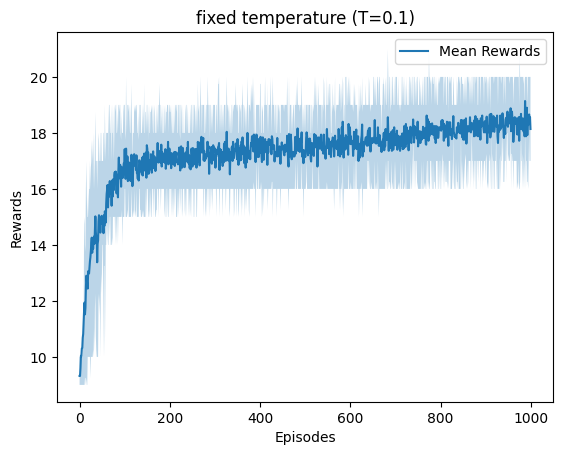

In [67]:
# Tuning completed for fixed T cartpole
gamma = 0.1 #tested
alpha = 5e-5 #lr for critic tested
beta = 0.5 #lr for actor tested
initial_temp = 0.1 #tested
temp_decay = 1 #doesnt apply for fixed T
temp_min = 0.1 #doesn't apple for fixed T


num_trials = 50
num_episodes = 1000

env_name ='CartPole-v1'


temp_decay = 1.0
results = run_experiments(env_name, gamma, alpha, beta, initial_temp, temp_decay, temp_min, num_trials, num_episodes)
plot_results(results, 'fixed temperature (T=0.1)')


##Cartpole Decaying T (T=0.1, decay factor=0.9)

[9.0, 9.0, 8.0, 10.0, 10.0, 10.0, 8.0, 9.0, 9.0, 9.0, 9.0, 12.0, 12.0, 19.0, 18.0, 15.0, 16.0, 10.0, 9.0, 9.0, 10.0, 10.0, 11.0, 20.0, 17.0, 18.0, 14.0, 16.0, 17.0, 14.0, 18.0, 17.0, 16.0, 18.0, 18.0, 16.0, 14.0, 18.0, 14.0, 17.0, 20.0, 16.0, 14.0, 15.0, 15.0, 17.0, 19.0, 17.0, 16.0, 18.0, 17.0, 17.0, 16.0, 16.0, 15.0, 14.0, 19.0, 14.0, 17.0, 18.0, 17.0, 14.0, 15.0, 15.0, 16.0, 15.0, 17.0, 18.0, 18.0, 19.0, 16.0, 15.0, 16.0, 21.0, 15.0, 15.0, 18.0, 15.0, 18.0, 14.0, 18.0, 18.0, 15.0, 14.0, 16.0, 16.0, 17.0, 17.0, 17.0, 16.0, 14.0, 15.0, 19.0, 18.0, 20.0, 19.0, 15.0, 19.0, 14.0, 18.0, 16.0, 20.0, 15.0, 20.0, 20.0, 17.0, 14.0, 20.0, 16.0, 20.0, 15.0, 20.0, 14.0, 16.0, 16.0, 17.0, 14.0, 15.0, 20.0, 17.0, 15.0, 16.0, 17.0, 23.0, 16.0, 17.0, 19.0, 16.0, 16.0, 18.0, 16.0, 15.0, 17.0, 16.0, 15.0, 18.0, 19.0, 18.0, 18.0, 16.0, 17.0, 16.0, 18.0, 20.0, 16.0, 15.0, 16.0, 20.0, 18.0, 17.0, 15.0, 21.0, 17.0, 16.0, 16.0, 15.0, 15.0, 18.0, 18.0, 16.0, 17.0, 18.0, 16.0, 16.0, 18.0, 14.0, 15.0, 21.0, 1

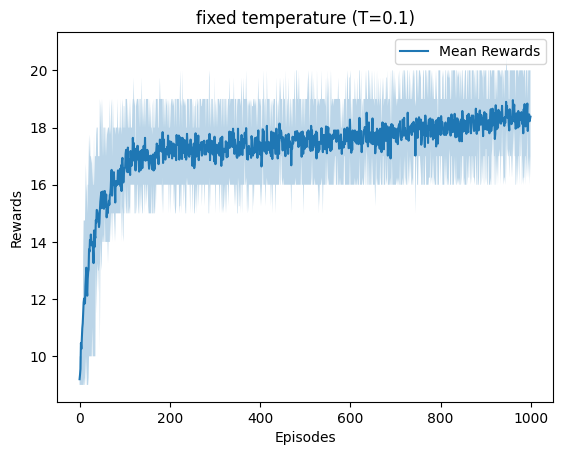

In [68]:
# Tuning completed
gamma = 0.1
alpha = 5e-5 #lr for critic
beta = 0.5 #lr for actor
initial_temp = 0.1
temp_decay = 0.9
temp_min = 0.01


num_trials = 50
num_episodes = 1000

env_name ='CartPole-v1'
results = run_experiments(env_name, gamma, alpha, beta, initial_temp, temp_decay, temp_min, num_trials, num_episodes)
plot_results(results, 'fixed temperature (T=0.1)')

##Mountain Car Fixed T

mean_timestesp
[1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001.
 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001.
 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001.
 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001.
 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001.
 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001.
 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001.
 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001.
 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001.
 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001.
 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001.
 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001.
 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001.
 1001. 1001. 1001. 1001. 1001. 1001.

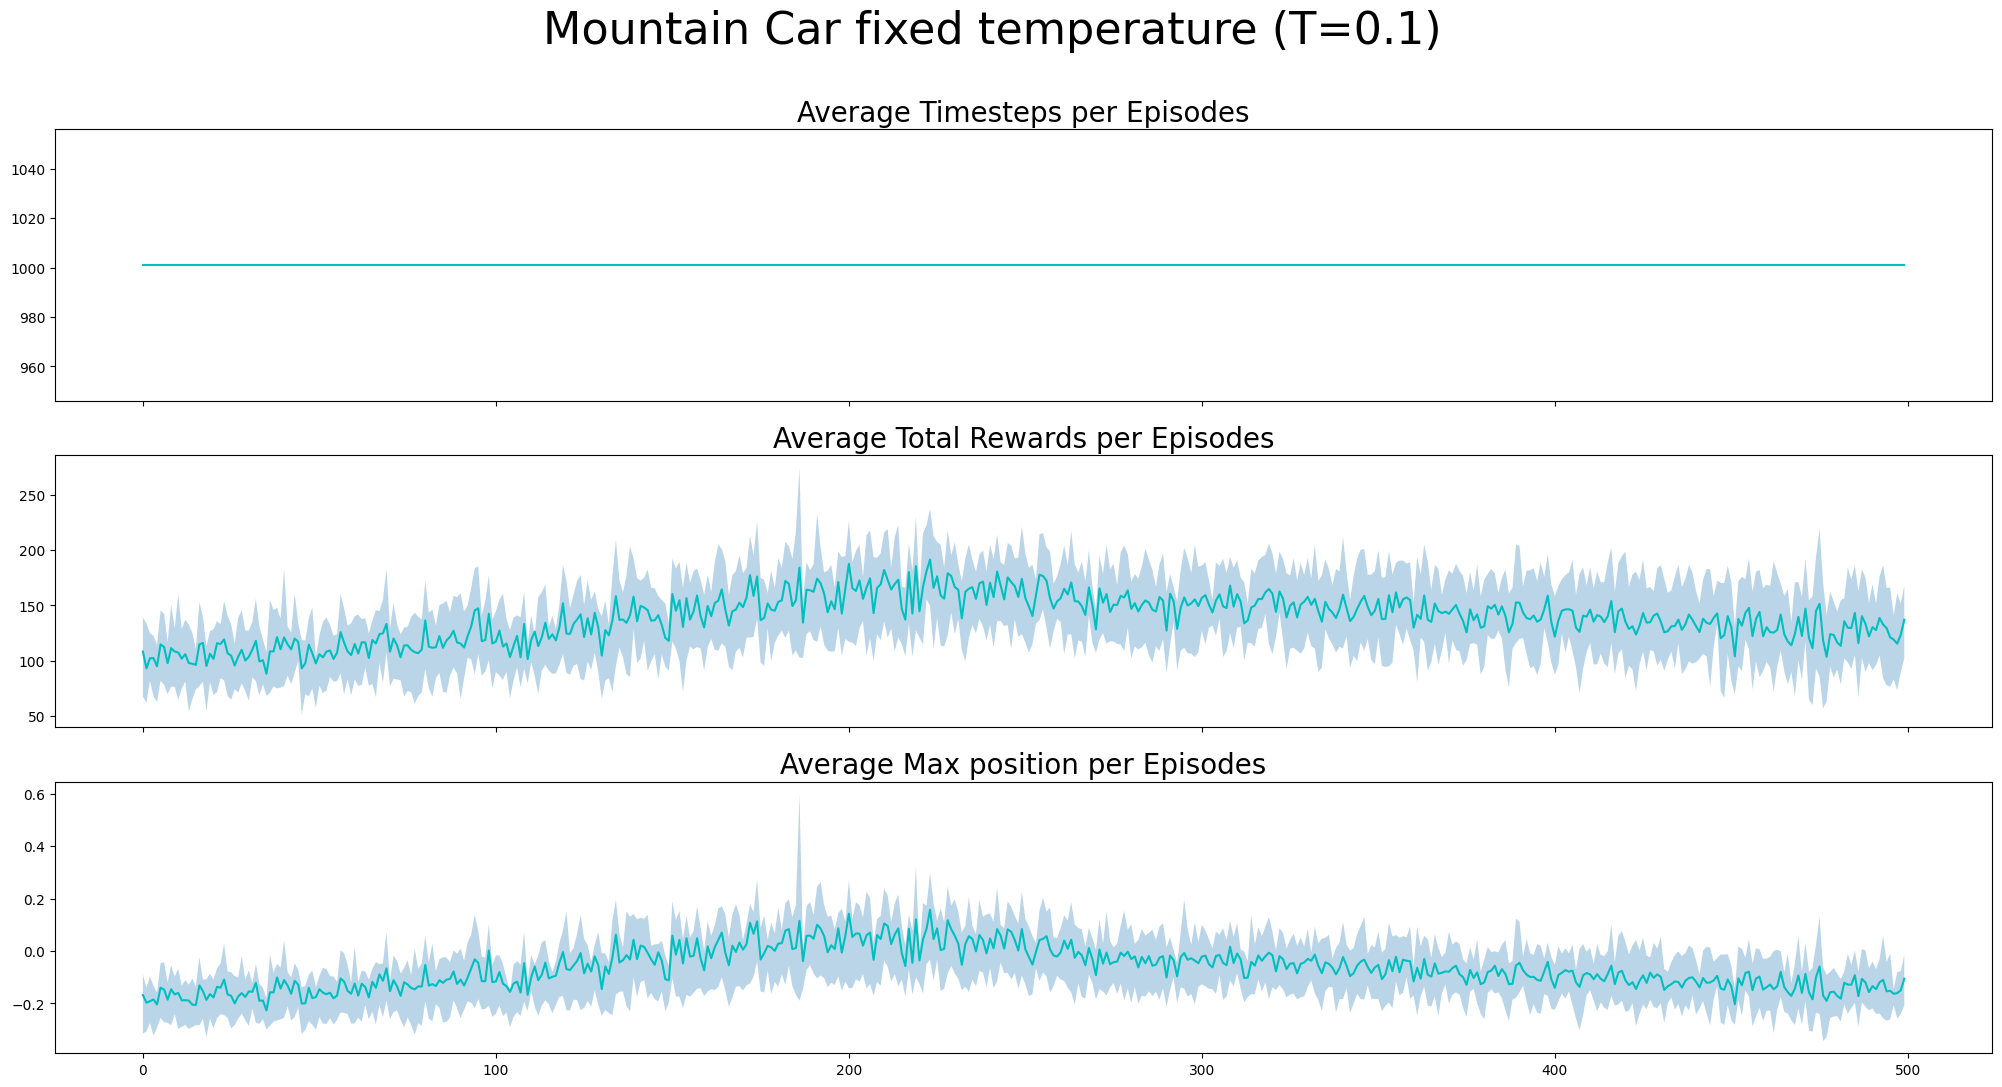

In [174]:
# Tuned parameters
gamma = 0.5 #tested
alpha = 1e-4 #lr for critic tested
beta = 1e-4 #lr for actor  tested
initial_temp = 0.1 #0.1
temp_decay = 1.0 #fixed T
temp_min = 0.1 #0.1

positive_reward_factor=1 #1 [0.1(no),1,10(test)]
negative_reward_factor=0.1
speed_factor=5


num_trials = 50
num_episodes = 500

env_name ='MountainCar-v0'
timestep,total_rewards,maxpos= run_experiments_MC(env_name, gamma, alpha, beta, initial_temp, temp_decay, temp_min, num_trials, num_episodes,
                                                  positive_reward_factor=1,negative_reward_factor=0.5,
                                                    speed_factor=5)
plot_results_MC(timestep,total_rewards,maxpos, 'c','Mountain Car fixed temperature (T=0.1)')

##Mountain Car Decaying T

mean_timestesp
[1000.   1000.   1000.   1000.   1000.   1000.   1000.   1000.   1000.
 1000.   1000.   1000.   1000.   1000.   1000.   1000.   1000.   1000.
 1000.   1000.   1000.   1000.   1000.   1000.   1000.   1000.   1000.
 1000.   1000.   1000.   1000.    996.48 1000.   1000.   1000.   1000.
 1000.   1000.    985.12 1000.   1000.   1000.   1000.   1000.   1000.
 1000.   1000.   1000.    992.68 1000.   1000.   1000.   1000.   1000.
 1000.   1000.   1000.    995.68 1000.   1000.   1000.    990.96 1000.
 1000.   1000.   1000.   1000.   1000.   1000.    990.96 1000.   1000.
 1000.    994.68 1000.    998.88 1000.   1000.   1000.   1000.   1000.
  991.16 1000.   1000.    996.16 1000.   1000.   1000.    999.16 1000.
 1000.   1000.   1000.   1000.    996.12 1000.   1000.   1000.   1000.
 1000.    982.84 1000.   1000.   1000.   1000.    995.   1000.   1000.
  998.8  1000.   1000.    997.4  1000.    996.72 1000.   1000.    995.84
 1000.   1000.    989.12  985.16  994.16  992.56  997.84  98

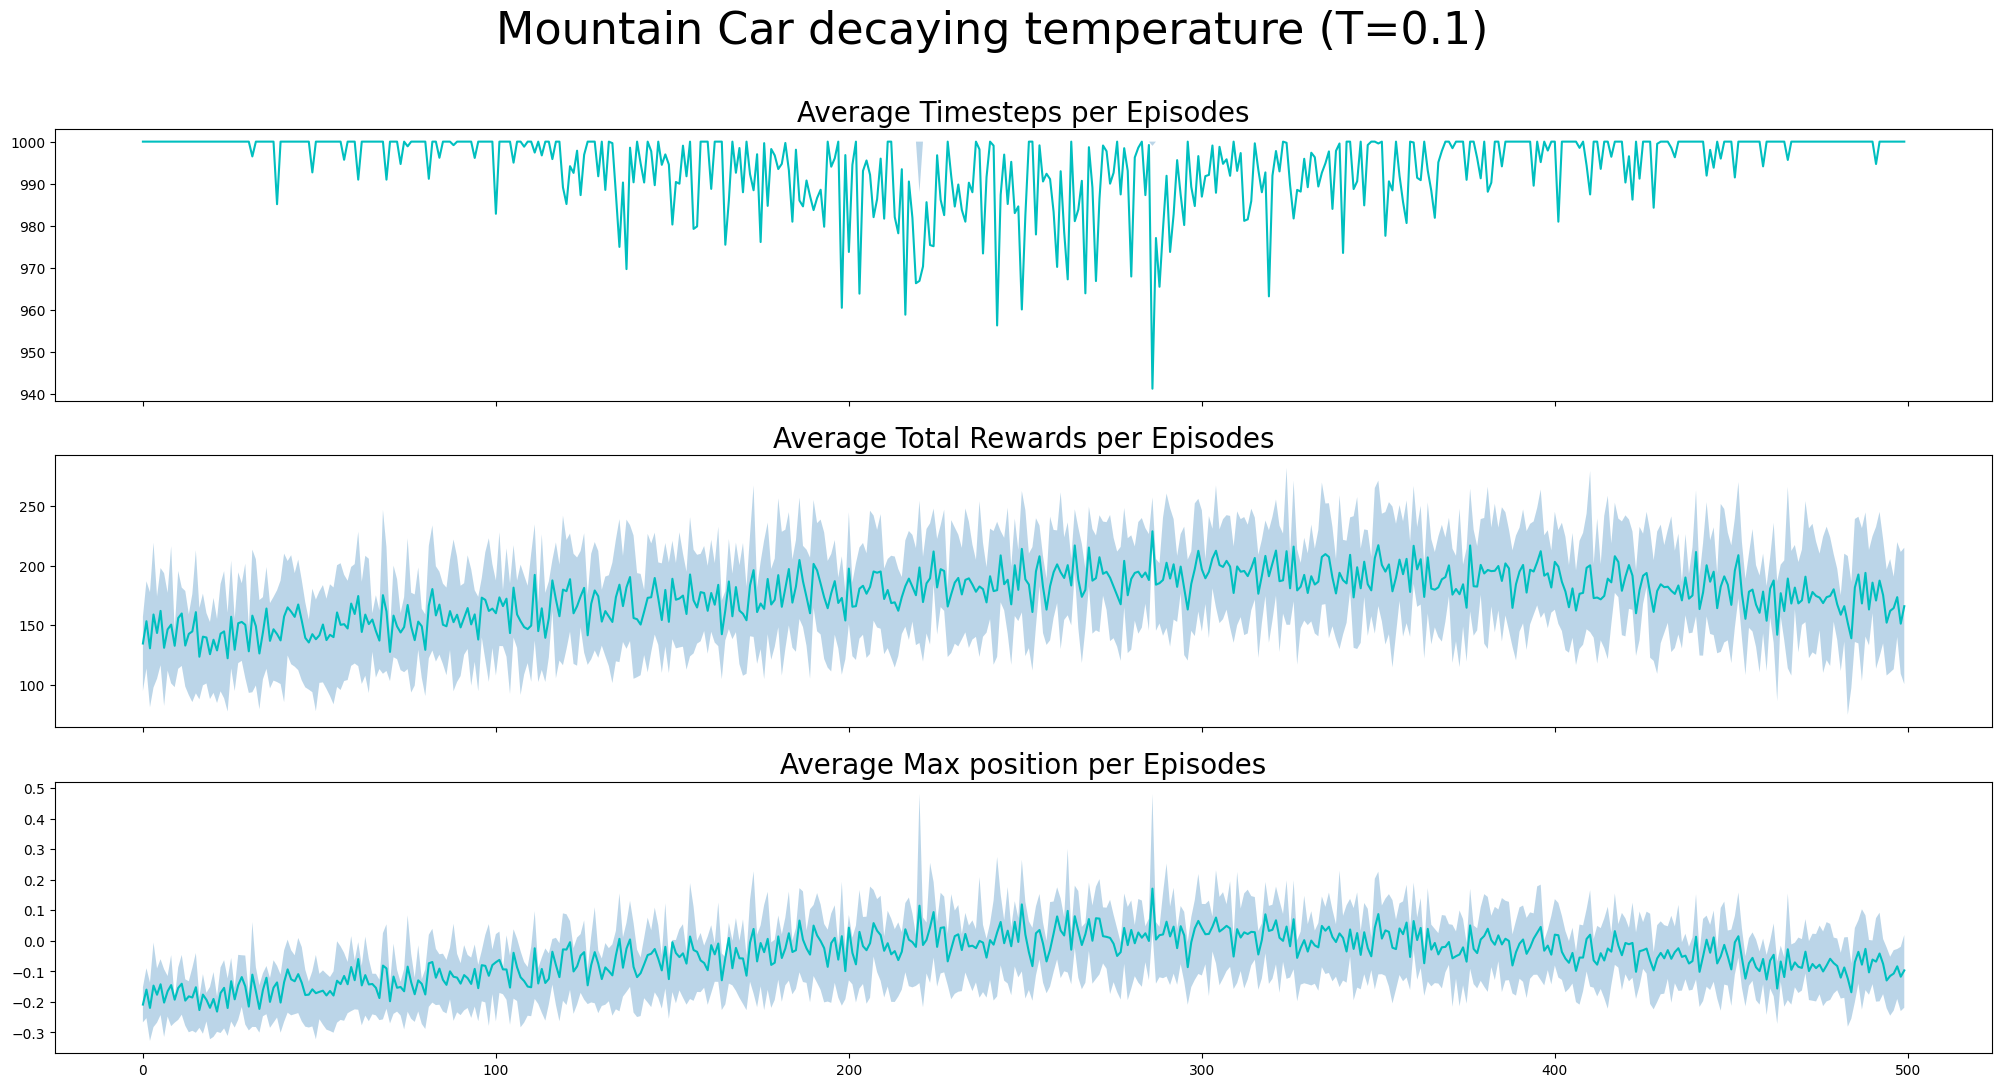

In [198]:
# Tuning for cartpole
gamma = 0.5 #tested
alpha = 1e-4 #lr for critic tested
beta = 1e-4 #lr for actor  tested
initial_temp = 0.99 #0.1
temp_decay = 0.99 #fixed T
temp_min = 0.1 #0.1

positive_reward_factor=1 #1
negative_reward_factor=0.1
speed_factor=10

num_trials = 25
num_episodes = 500

env_name ='MountainCar-v0'

timestep,total_rewards,maxpos= run_experiments_MC(env_name, gamma, alpha, beta, initial_temp, temp_decay, temp_min , num_trials, num_episodes,
                                                  positive_reward_factor=positive_reward_factor,negative_reward_factor=0.1,
                                                    speed_factor=speed_factor)
plot_results_MC(timestep,total_rewards,maxpos, 'c','Mountain Car decaying temperature (T=0.1)')